In [1]:
import os
from os.path import join
import sys
import subprocess
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import sklearn
import random
import string 
import scipy
import seaborn as sns
from pickle import load, dump
from collections import Counter
import re
import pprint

import gensim
from gensim.models import word2vec, Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.models import KeyedVectors
from gensim.utils import tokenize
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from wordcloud import WordCloud
from PIL import Image

import spacy

import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
import unicodedata

In [2]:
%matplotlib inline

In [3]:
os.getcwd()

'C:\\Users\\vnarv\\PycharmProjects\\twitter_text_mining\\notebooks'

In [4]:
path = "C:/Users/vnarv/PycharmProjects/twitter_text_mining/"
os.chdir(path)

In [5]:
from src.preprocessing.tools_preprocessing import *
from src.preprocessing.preprocessing_main import *

In [6]:
raw_data = read_files(os.path.join(path, "data/test/"))
print(raw_data.shape)
data = transform_dates(raw_data)
data = preprocessing(data)
data.to_csv(path + "/data/test/df_prepro.csv",sep=";", index=False)

C:\Users\vnarv\PycharmProjects\twitter_text_mining
Something went wrong
(19939, 8)
Nb of tweets detected in other language language
af     7
ca     9
cs     1
da     5
de    12
en    73
es     4
et    11
fi    14
hr     3
id     5
it    30
lt     6
lv     1
nl     4
no    14
pl     2
ro     2
sk     1
sl     3
sv     1
Name: tweet_id, dtype: int64
                                             text_clean language
93          desescaladez vladimir par cocoboer ukraine        es
192   spanish minister of foreign affairs jose manue...       en
366    flash une invasion russe de l ukraine est pos...       en
386    g finance ministers statement on ukraine g g ger       en
430         convoidelaliberte ukraine atomium lesoirbe        it
703    editionspeciale ukraine a h edition speciale ...       en
1148  ukraine foreign ministry recalls charge d affa...       en
1310  a la une de liberation ce mercredi ukraine fac...       it
1502          explosions in kyiv via neilphauer ukraine       fi


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vnarv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\preprocessing\preprocessing_main.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_clean"] = [' '.join([word for word in doc.split() if word not in french_stopwords_list]) for doc in
C:\Users\vnarv\PycharmProjects\twitter_text_mining\src\preprocessing\preprocessing_main.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [7]:
data = pd.read_csv(path + "/data/test/df_prepro.csv",sep=";")

In [9]:
data.columns

Index(['datetime', 'tweet_id', 'text', 'username', 'like_count',
       'retweet_count', 'reply_count', 'quote_count', 'date', 'day', 'month',
       'time', 'hour', 'minute', 'hashtags', 'arrobas', 'text_clean',
       'language', 'text_stem', 'text_lemma', 'text_lemma_bigrame',
       'text_lemma_trigrame'],
      dtype='object')

In [10]:
# to do : add to preprocessing
def generate_ngrams(s, n):
    tokens = [token for token in s.split(" ") if token != ""]
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return ["_".join(ngram) for ngram in ngrams]

data["text_lemma_bigrame"] = [' '.join([word for word in generate_ngrams(doc, 2) if len(word) > 1]) for doc in data["text_clean"]]
data["text_lemma_trigrame"] = [' '.join([word for word in generate_ngrams(doc, 3) if len(word) > 1]) for doc in data["text_clean"]]
#data["text_lemma_bigrame"] = data["text_lemma"].apply(lambda x: generate_ngrams(x, 2))

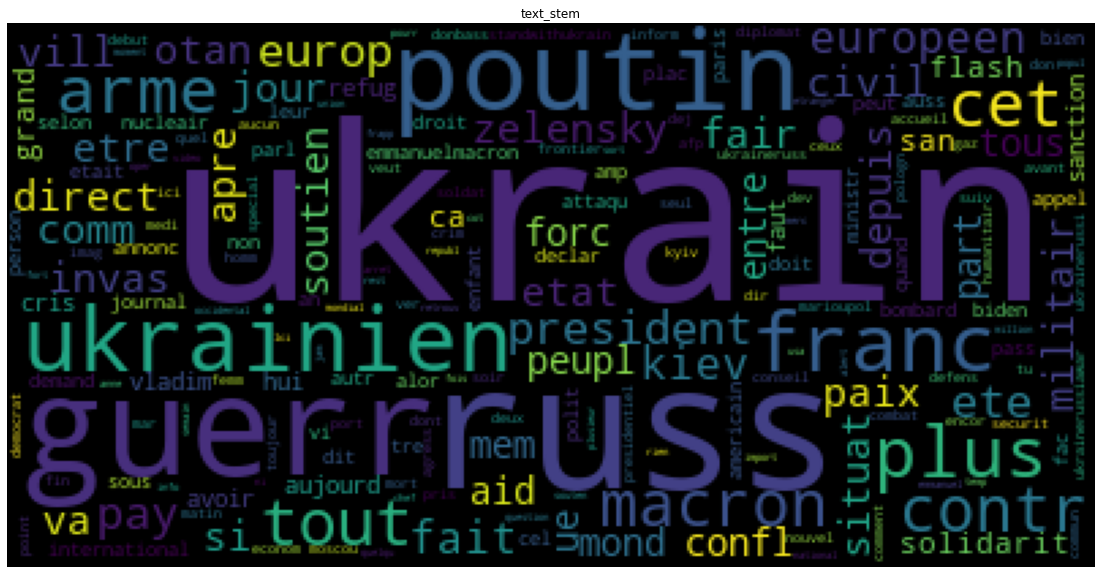

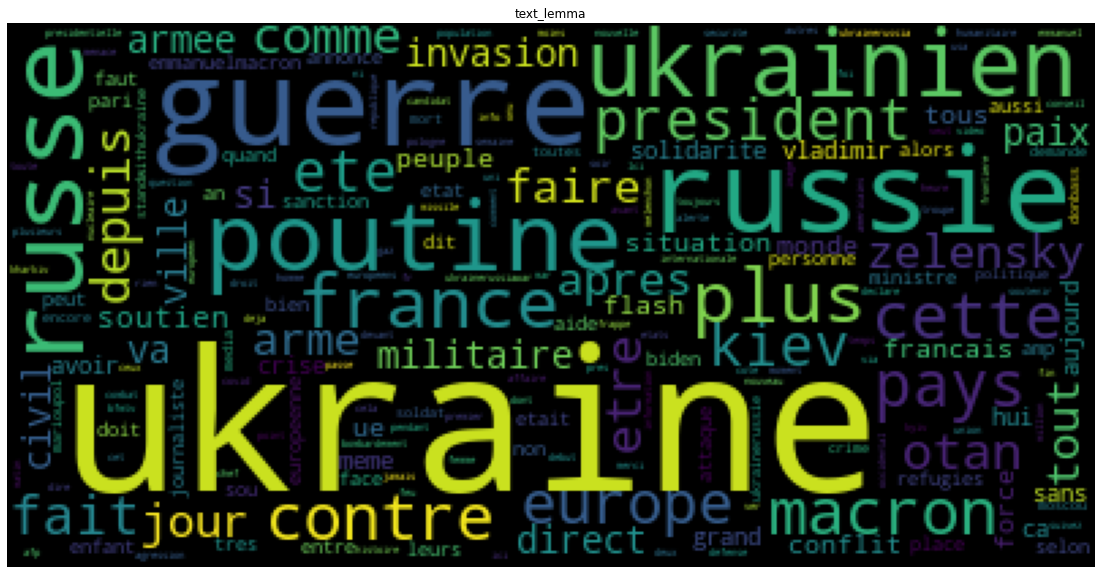

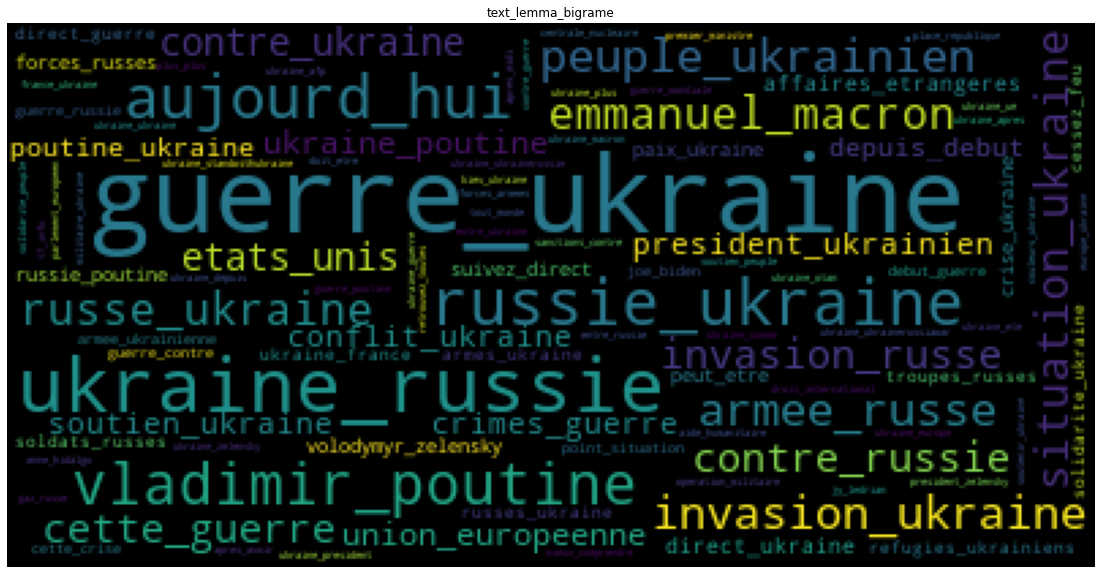

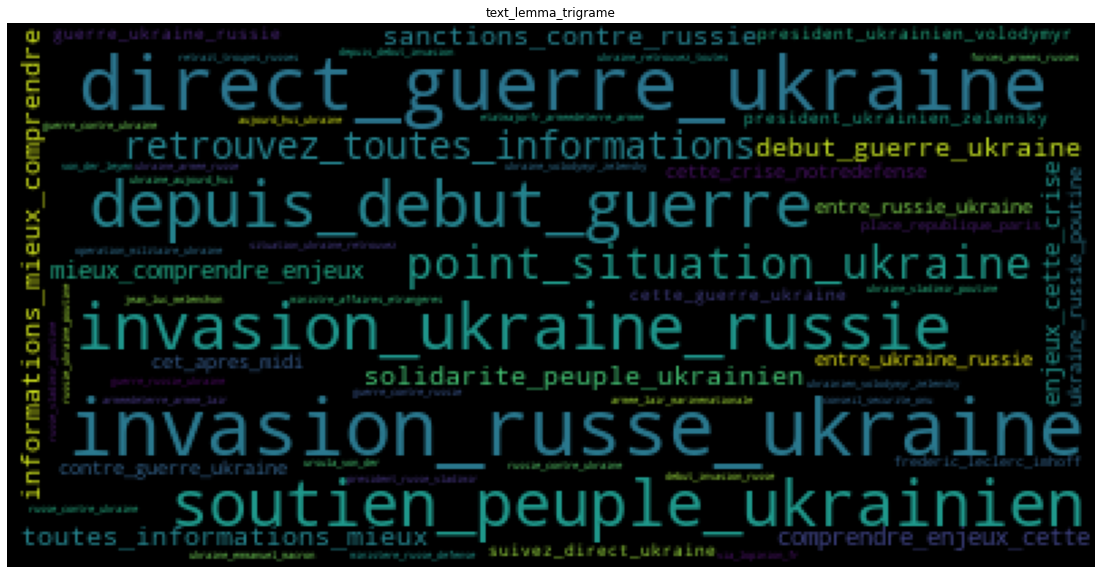

In [11]:
for method in ["text_stem", "text_lemma", "text_lemma_bigrame", "text_lemma_trigrame"]:
    words_t = ''
    for i in data[method]:
        words_t += '{} '.format(i.lower())
    wd = pd.DataFrame(Counter(words_t.split()).most_common(), columns=['word', 'frequency_total'])
    tuples = [tuple(x) for x in wd.values]
    wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
    plt.subplots(figsize=(20, 10)) 
    plt.imshow(wordcloud)
    plt.title(f"{method}") 
    plt.axis("off")
    plt.show()

# LDA

In [12]:
# vectorize
def compute_bag_of_words(df):
    # split each tweet sentence into words
    text_tokens = [[text for text in tweet.split()] for tweet in df]
    # create a dictionary 
    dico_words = corpora.Dictionary(text_tokens)
    # Filter too common or rare words 
    dico_words.filter_extremes(no_below=10, no_above=0.95)
    # computes the frequency of each word in the dictionary (dico_words)
    doc_term_matrix = [dico_words.doc2bow(rev) for rev in text_tokens]
    return(text_tokens, dico_words, doc_term_matrix)


def compute_lda(dictionary, corpus, texts, num_topics):
    start = time.time()
    LDA = gensim.models.ldamodel.LdaModel
    # Build LDA model
    lda_model = LDA(
                corpus,
                id2word=dictionary,
                num_topics=num_topics,
                random_state=100,
                chunksize=100,
        alpha='auto',
        passes=5, per_word_topics=True)
    
    end = time.time()
    delta = (end- start)/60
    print(f"\n\nModel took : {delta:.2} minutes")
    
    topics = []
    for idx, topic in lda_model.print_topics(-1) :
        print("Topic: {} -> Words: {}".format(idx, topic))
    topics.append(topic)
    
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'\nCoherence Score: {coherence_lda:.2}')
    #0.33063023037515266
    return lda_model, coherence_lda

def graph_nb_topics(start, limit, step, coherence_values):
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

def search_nb_topics(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # todo: transform into a function
        model = compute_lda(dictionary=dictionary,
                 corpus=corpus,
                 texts=texts,
                 num_topics=num_topics)
        coherence_values.append(model[1])
    
    # show graph
    graph_nb_topics(start, limit, step, coherence_values)
    
    best_values = [index for index, value in enumerate(coherence_values) if value == max(coherence_values)]
    
    return best_values[0] + start



In [19]:
# text_tokens_lemma, dico_words_lemma, doc_term_matrix_lemma = compute_bag_of_words(data["text_lemma"])
# start = time.time()
# LDA = gensim.models.ldamodel.LdaModel

# # Build LDA model
# lda_model_lemma = LDA(
#                 corpus=doc_term_matrix_lemma,
#                 id2word=dico_words_lemma,
#                 num_topics=3,
#                 random_state=100,
#                 chunksize=200, passes=5, per_word_topics=True)


# end = time.time()
# delta = (end- start)/60
# print(f"Model took : {delta:.2} minutes")


5



Model took : 0.22 minutes
Topic: 0 -> Words: 0.012*"europe" + 0.011*"ue" + 0.010*"france" + 0.008*"contre" + 0.007*"fait" + 0.007*"depuis" + 0.007*"soutien" + 0.007*"francais" + 0.007*"kiev" + 0.007*"president"
Topic: 1 -> Words: 0.031*"guerre" + 0.025*"russie" + 0.022*"russe" + 0.016*"ukrainien" + 0.013*"poutine" + 0.012*"macron" + 0.012*"plus" + 0.008*"zelensky" + 0.008*"pays" + 0.007*"ete"

Coherence Score: 0.22


Model took : 0.26 minutes
Topic: 0 -> Words: 0.018*"contre" + 0.018*"europe" + 0.013*"arme" + 0.011*"francais" + 0.010*"fait" + 0.010*"situation" + 0.009*"an" + 0.009*"donbass" + 0.009*"crime" + 0.009*"direct"
Topic: 1 -> Words: 0.048*"guerre" + 0.036*"russie" + 0.020*"france" + 0.019*"poutine" + 0.019*"macron" + 0.012*"zelensky" + 0.010*"president" + 0.010*"otan" + 0.008*"etre" + 0.008*"comme"
Topic: 2 -> Words: 0.035*"russe" + 0.029*"ukrainien" + 0.017*"plus" + 0.013*"ete" + 0.012*"kiev" + 0.011*"armee" + 0.010*"jour" + 0.009*"soutien" + 0.009*"pays" + 0.009*"civil"

C

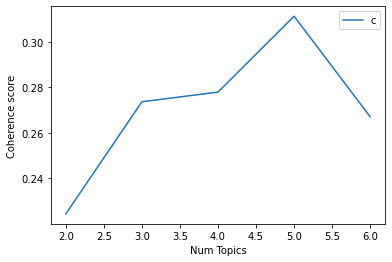



Model took : 0.24 minutes
Topic: 0 -> Words: 0.024*"ete" + 0.021*"depuis" + 0.020*"kiev" + 0.019*"cette" + 0.017*"apres" + 0.016*"jour" + 0.016*"francais" + 0.015*"civil" + 0.014*"situation" + 0.013*"an"
Topic: 1 -> Words: 0.035*"poutine" + 0.034*"macron" + 0.021*"zelensky" + 0.017*"otan" + 0.016*"president" + 0.015*"comme" + 0.014*"faire" + 0.014*"va" + 0.013*"si" + 0.012*"crime"
Topic: 2 -> Words: 0.093*"russe" + 0.020*"direct" + 0.019*"mort" + 0.013*"grand" + 0.012*"annonce" + 0.011*"personne" + 0.011*"sou" + 0.010*"bombardement" + 0.010*"cote" + 0.009*"combat"
Topic: 3 -> Words: 0.048*"ukrainien" + 0.040*"russie" + 0.023*"ue" + 0.020*"pays" + 0.017*"arme" + 0.012*"armee" + 0.011*"monde" + 0.011*"tout" + 0.010*"force" + 0.010*"europeenne"
Topic: 4 -> Words: 0.075*"guerre" + 0.030*"france" + 0.027*"plus" + 0.021*"europe" + 0.020*"contre" + 0.018*"russie" + 0.016*"fait" + 0.013*"soutien" + 0.012*"etre" + 0.011*"emmanuelmacron"

Coherence Score: 0.31


C:\Users\vnarv\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [13]:
text_tokens_lemma, dico_words_lemma, doc_term_matrix_lemma = compute_bag_of_words(data["text_lemma"])
best_topics_lemma = search_nb_topics(dictionary=dico_words_lemma,
                                    corpus=doc_term_matrix_lemma,
                                    texts=text_tokens_lemma,
                                    start=2, limit=7, step=1)


lda_lemma, score_lemma = compute_lda(dictionary=dico_words_lemma, corpus=doc_term_matrix_lemma, texts=text_tokens_lemma, num_topics=best_topics_lemma)


vis = gensimvis.prepare(topic_model=lda_lemma, corpus=doc_term_matrix_lemma, dictionary=dico_words_lemma)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_lemma.html')

In [ ]:
# #print(dico_words.token2id)
# #print(doc_term_matrix)
# print(len(doc_term_matrix[0]))
# print(doc_term_matrix[0])
# # visualize frequency with the correspondent word
# [[(dico_words[i], freq) for i, freq in doc] for doc in doc_term_matrix[:1]]

In [ ]:
#type(dico_words_lemma.keys())



Model took : 0.26 minutes
Topic: 0 -> Words: 0.044*"russ" + 0.022*"guerr" + 0.013*"arme" + 0.012*"poutin" + 0.010*"plus" + 0.009*"contr" + 0.008*"ete" + 0.008*"ukrainien" + 0.007*"pay" + 0.007*"kiev"
Topic: 1 -> Words: 0.023*"franc" + 0.016*"macron" + 0.013*"cet" + 0.013*"guerr" + 0.012*"ukrainien" + 0.011*"europ" + 0.011*"tout" + 0.011*"europeen" + 0.009*"president" + 0.009*"ue"

Coherence Score: 0.26


Model took : 0.24 minutes
Topic: 0 -> Words: 0.072*"russ" + 0.021*"arme" + 0.014*"contr" + 0.014*"ete" + 0.011*"kiev" + 0.009*"otan" + 0.009*"plus" + 0.008*"direct" + 0.008*"civil" + 0.008*"militair"
Topic: 1 -> Words: 0.052*"guerr" + 0.025*"ukrainien" + 0.021*"macron" + 0.020*"poutin" + 0.014*"europ" + 0.013*"zelensky" + 0.012*"president" + 0.010*"cet" + 0.009*"soutien" + 0.008*"parl"
Topic: 2 -> Words: 0.031*"franc" + 0.015*"tout" + 0.015*"ue" + 0.014*"europeen" + 0.012*"fait" + 0.011*"plus" + 0.009*"faut" + 0.009*"etre" + 0.008*"va" + 0.008*"depuis"

Coherence Score: 0.31


Model 

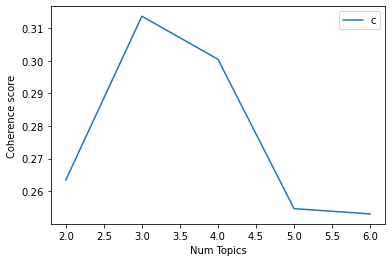



Model took : 0.23 minutes
Topic: 0 -> Words: 0.072*"russ" + 0.021*"arme" + 0.014*"contr" + 0.014*"ete" + 0.011*"kiev" + 0.009*"otan" + 0.009*"plus" + 0.008*"direct" + 0.008*"civil" + 0.008*"militair"
Topic: 1 -> Words: 0.052*"guerr" + 0.025*"ukrainien" + 0.021*"macron" + 0.020*"poutin" + 0.014*"europ" + 0.013*"zelensky" + 0.012*"president" + 0.010*"cet" + 0.009*"soutien" + 0.008*"parl"
Topic: 2 -> Words: 0.031*"franc" + 0.015*"tout" + 0.015*"ue" + 0.014*"europeen" + 0.012*"fait" + 0.011*"plus" + 0.009*"faut" + 0.009*"etre" + 0.008*"va" + 0.008*"depuis"

Coherence Score: 0.31


C:\Users\vnarv\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [14]:
# stem
text_tokens_stem, dico_words_stem, doc_term_matrix_stem = compute_bag_of_words(data["text_stem"])
best_topics_stem = search_nb_topics(dictionary=dico_words_stem,
                                    corpus=doc_term_matrix_stem,
                                    texts=text_tokens_stem,
                                    start=2, limit=7, step=1)

lda_stem, score_stem = compute_lda(dictionary=dico_words_stem, corpus=doc_term_matrix_stem, texts=text_tokens_stem, num_topics=best_topics_stem)


vis = gensimvis.prepare(topic_model=lda_stem, corpus=doc_term_matrix_stem, dictionary=dico_words_stem)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_stem.html')



Model took : 0.17 minutes
Topic: 0 -> Words: 0.084*"guerre_ukraine" + 0.016*"russie_ukraine" + 0.011*"armee_russe" + 0.011*"crimes_guerre" + 0.009*"vladimir_poutine" + 0.008*"russe_ukraine" + 0.008*"ukraine_france" + 0.008*"direct_guerre" + 0.008*"cette_guerre" + 0.008*"soutien_ukraine"
Topic: 1 -> Words: 0.029*"ukraine_russie" + 0.023*"aujourd_hui" + 0.012*"emmanuel_macron" + 0.011*"union_europeenne" + 0.009*"contre_russie" + 0.009*"point_situation" + 0.008*"volodymyr_zelensky" + 0.008*"situation_ukraine" + 0.007*"mieux_comprendre" + 0.007*"invasion_ukraine"

Coherence Score: 0.45


Model took : 0.18 minutes
Topic: 0 -> Words: 0.105*"guerre_ukraine" + 0.028*"aujourd_hui" + 0.020*"russie_ukraine" + 0.014*"crimes_guerre" + 0.014*"armee_russe" + 0.011*"ukraine_france" + 0.010*"russe_ukraine" + 0.010*"soutien_ukraine" + 0.010*"cette_guerre" + 0.009*"invasion_russe"
Topic: 1 -> Words: 0.046*"ukraine_russie" + 0.020*"emmanuel_macron" + 0.018*"union_europeenne" + 0.016*"vladimir_poutine" +


Coherence Score: 0.6


Model took : 0.18 minutes
Topic: 0 -> Words: 0.045*"armee_russe" + 0.036*"centre_commercial" + 0.032*"cette_guerre" + 0.023*"armes_ukraine" + 0.023*"accords_minsk" + 0.015*"contre_ukraine" + 0.014*"suivez_direct" + 0.014*"ukraine_situation" + 0.013*"quelques_jours" + 0.013*"defendre_ukraine"
Topic: 1 -> Words: 0.042*"direct_guerre" + 0.041*"contre_russie" + 0.033*"conflit_ukraine" + 0.030*"mieux_comprendre" + 0.024*"russie_donbass" + 0.023*"ukraine_juin" + 0.023*"situation_militaire" + 0.022*"affaires_etrangeres" + 0.020*"europe_ukraine" + 0.019*"soir_russie"
Topic: 2 -> Words: 0.056*"ukraine_ue" + 0.038*"carte_situation" + 0.032*"doit_etre" + 0.024*"faut_mettre" + 0.022*"forces_rus" + 0.022*"adhesion_ukraine" + 0.021*"ukraine_otan" + 0.021*"parlement_ukrainien" + 0.019*"ukraine_doit" + 0.019*"russes_ukraine"
Topic: 3 -> Words: 0.043*"ukraine_moldavie" + 0.032*"ukraine_macron" + 0.024*"ukraine_comme" + 0.021*"ukraine_depuis" + 0.019*"securite_alimentaire" + 0.01

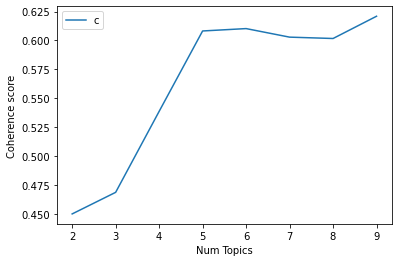



Model took : 0.18 minutes
Topic: 0 -> Words: 0.045*"armee_russe" + 0.036*"centre_commercial" + 0.032*"cette_guerre" + 0.023*"armes_ukraine" + 0.023*"accords_minsk" + 0.015*"contre_ukraine" + 0.014*"suivez_direct" + 0.014*"ukraine_situation" + 0.013*"quelques_jours" + 0.013*"defendre_ukraine"
Topic: 1 -> Words: 0.042*"direct_guerre" + 0.041*"contre_russie" + 0.033*"conflit_ukraine" + 0.030*"mieux_comprendre" + 0.024*"russie_donbass" + 0.023*"ukraine_juin" + 0.023*"situation_militaire" + 0.022*"affaires_etrangeres" + 0.020*"europe_ukraine" + 0.019*"soir_russie"
Topic: 2 -> Words: 0.056*"ukraine_ue" + 0.038*"carte_situation" + 0.032*"doit_etre" + 0.024*"faut_mettre" + 0.022*"forces_rus" + 0.022*"adhesion_ukraine" + 0.021*"ukraine_otan" + 0.021*"parlement_ukrainien" + 0.019*"ukraine_doit" + 0.019*"russes_ukraine"
Topic: 3 -> Words: 0.043*"ukraine_moldavie" + 0.032*"ukraine_macron" + 0.024*"ukraine_comme" + 0.021*"ukraine_depuis" + 0.019*"securite_alimentaire" + 0.019*"soldats_russes" + 0

C:\Users\vnarv\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [15]:
# bigrammes
text_tokens_bigram, dico_words_bigram, doc_term_matrix_bigram = compute_bag_of_words(data["text_lemma_bigrame"])

best_topics_bigram = search_nb_topics(dictionary=dico_words_bigram,
                                                        corpus=doc_term_matrix_bigram,
                                                        texts=text_tokens_bigram,
                                                        start=2, limit=10, step=1)

lda_bigram, score_bigram = compute_lda(dictionary=dico_words_bigram, corpus=doc_term_matrix_bigram, texts=text_tokens_bigram, num_topics=best_topics_bigram)

vis = gensimvis.prepare(topic_model=lda_bigram, corpus=doc_term_matrix_bigram, dictionary=dico_words_bigram)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_bigram.html')



Model took : 0.12 minutes
Topic: 0 -> Words: 0.047*"direct_guerre_ukraine" + 0.040*"frederic_leclerc_imhoff" + 0.026*"carte_situation_militaire" + 0.025*"situation_militaire_ukraine" + 0.025*"militaire_ukraine_juin" + 0.023*"soir_russie_donbass" + 0.023*"juin_soir_russie" + 0.023*"ukraine_juin_soir" + 0.022*"invasion_russe_ukraine" + 0.019*"guerre_ukraine_russie"
Topic: 1 -> Words: 0.039*"point_situation_ukraine" + 0.038*"retrouvez_toutes_informations" + 0.038*"mieux_comprendre_enjeux" + 0.038*"informations_mieux_comprendre" + 0.038*"enjeux_cette_crise" + 0.038*"comprendre_enjeux_cette" + 0.038*"cette_crise_notredefense" + 0.038*"toutes_informations_mieux" + 0.037*"armee_lair_marinenationale" + 0.037*"ukraine_retrouvez_toutes"

Coherence Score: 0.73


Model took : 0.12 minutes
Topic: 0 -> Words: 0.085*"direct_guerre_ukraine" + 0.065*"frederic_leclerc_imhoff" + 0.047*"carte_situation_militaire" + 0.047*"situation_militaire_ukraine" + 0.047*"militaire_ukraine_juin" + 0.043*"ukraine_jui


Coherence Score: 0.7


Model took : 0.13 minutes
Topic: 0 -> Words: 0.149*"invasion_russe_ukraine" + 0.083*"von_der_leyen" + 0.070*"ursula_von_der" + 0.069*"cet_apres_midi" + 0.067*"ukraine_vladimir_poutine" + 0.065*"aujourd_hui_ukraine" + 0.046*"depuis_debut_invasion" + 0.042*"eme_jour_invasion" + 0.042*"jour_invasion_russe" + 0.039*"debut_invasion_russe"
Topic: 1 -> Words: 0.104*"guerre_ukraine_russie" + 0.049*"crimes_guerre_commis" + 0.049*"guerre_russie_ukraine" + 0.048*"crimes_guerre_ukraine" + 0.036*"russie_ukraine_poutine" + 0.036*"crimes_contre_humanite" + 0.031*"toulouse_montpellier_herault" + 0.031*"montpellier_herault_beziers" + 0.030*"occitanie_toulouse_montpellier" + 0.030*"russie_poutine_macron"
Topic: 2 -> Words: 0.232*"frederic_leclerc_imhoff" + 0.103*"cette_guerre_ukraine" + 0.075*"via_lopinion_fr" + 0.062*"jour_invasion_ukraine" + 0.057*"place_republique_paris" + 0.053*"agression_russe_ukraine" + 0.052*"invasion_ukraine_russie" + 0.045*"jdomerchet_lopinion_fr" + 0.02

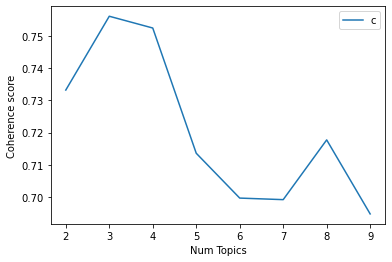



Model took : 0.12 minutes
Topic: 0 -> Words: 0.085*"direct_guerre_ukraine" + 0.065*"frederic_leclerc_imhoff" + 0.047*"carte_situation_militaire" + 0.047*"situation_militaire_ukraine" + 0.047*"militaire_ukraine_juin" + 0.043*"ukraine_juin_soir" + 0.043*"soir_russie_donbass" + 0.043*"juin_soir_russie" + 0.039*"invasion_russe_ukraine" + 0.035*"guerre_ukraine_russie"
Topic: 1 -> Words: 0.037*"depuis_debut_guerre" + 0.037*"ukraine_aujourd_hui" + 0.033*"debut_guerre_ukraine" + 0.028*"ukraine_moldavie_georgie" + 0.025*"adhesion_union_europeenne" + 0.022*"depuis_debut_conflit" + 0.021*"cause_guerre_ukraine" + 0.021*"ukraine_vladimir_poutine" + 0.019*"via_lopinion_fr" + 0.019*"crimes_guerre_commis"
Topic: 2 -> Words: 0.040*"point_situation_ukraine" + 0.039*"retrouvez_toutes_informations" + 0.039*"informations_mieux_comprendre" + 0.039*"enjeux_cette_crise" + 0.039*"cette_crise_notredefense" + 0.039*"comprendre_enjeux_cette" + 0.039*"toutes_informations_mieux" + 0.039*"mieux_comprendre_enjeux" 

C:\Users\vnarv\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [16]:
# trigrames
text_tokens_trigram, dico_words_trigram, doc_term_matrix_trigram = compute_bag_of_words(data["text_lemma_trigrame"])

best_topics_trigram = search_nb_topics(dictionary=dico_words_trigram,
                                                        corpus=doc_term_matrix_trigram,
                                                        texts=text_tokens_trigram,
                                                        start=2, limit=10, step=1)

lda_trigram, score_trigram = compute_lda(dictionary=dico_words_trigram, corpus=doc_term_matrix_trigram, texts=text_tokens_trigram, num_topics=best_topics_trigram)

vis = gensimvis.prepare(topic_model=lda_trigram, corpus=doc_term_matrix_trigram, dictionary=dico_words_trigram)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_trigram.html')

# Assign a topic to each tweet 

In [34]:
 def format_topics_sentences(ldamodel, corpus, texts):
        
        # Init output
        sent_topics_df = pd.DataFrame()

        start = time.time()
        # Get main topic in each document
        for i, row_list in enumerate(ldamodel[corpus]):
            # per_word_topics: list of topics, sorted in descending order of most likely topics for each word
            row = row_list[0] if ldamodel.per_word_topics else row_list
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:  # => dominant topic
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
        end = time.time()
        delta = (end - start)/60
        print(f"Took {delta:.2} minutes")
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
        
        # Add original text to the end of the output
        contents = pd.Series(texts)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

        # format
        sent_topics_df = sent_topics_df.reset_index()
        sent_topics_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
        return(sent_topics_df)

def make_cloud(df, df_dominant_topic, vect_type):
    df[f"Dominant_Topic_{vect_type}"] = df_dominant_topic["Dominant_Topic"]
    color_list = ["summer", "winter", "Oranges", "seismic"]
    
    for i in df_dominant_topic["Dominant_Topic"].unique():
        color = random.choice(color_list)
        cloud = WordCloud(colormap=color, width=800, height=400).generate(str(
            df[df[f"Dominant_Topic_{vect_type}"]==i][f"text_{vect_type}"]))
        fig = plt.figure(figsize=(12,10))
        plt.axis("off")
        plt.imshow(cloud,interpolation='bilinear')
        plt.title(f"WordCloud for Topic {i}", size = 24)
        plt.show()

In [28]:
data.columns

Index(['datetime', 'tweet_id', 'text', 'username', 'like_count',
       'retweet_count', 'reply_count', 'quote_count', 'date', 'day', 'month',
       'time', 'hour', 'minute', 'hashtags', 'arrobas', 'text_clean',
       'language', 'text_stem', 'text_lemma', 'text_lemma_bigrame',
       'text_lemma_trigrame', 'Dominant_Topic_lemma', 'Dominant_Topic_stem'],
      dtype='object')

In [18]:
df_dominant_topics_lemma = format_topics_sentences(ldamodel=lda_lemma, corpus=doc_term_matrix_lemma, texts=text_tokens_lemma)

C:\Users\vnarv\AppData\Local\Temp\ipykernel_23256\3707445515.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\vnarv\AppData\Local\Temp\ipykernel_23256\3707445515.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [20]:
df_dominant_topics_stem = format_topics_sentences(ldamodel=lda_stem, corpus=doc_term_matrix_stem, texts=text_tokens_stem)

C:\Users\vnarv\AppData\Local\Temp\ipykernel_23256\3716732394.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\vnarv\AppData\Local\Temp\ipykernel_23256\3716732394.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Took 7.6 minutes


In [32]:
df_dominant_topics_bigrame = format_topics_sentences(ldamodel=lda_bigram, corpus=doc_term_matrix_bigram, texts=text_tokens_bigram)

C:\Users\vnarv\AppData\Local\Temp\ipykernel_23256\3716732394.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\vnarv\AppData\Local\Temp\ipykernel_23256\3716732394.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Took 8.0 minutes


In [40]:
df_dominant_topics_trigram = format_topics_sentences(ldamodel=lda_trigram, corpus=doc_term_matrix_trigram, texts=text_tokens_trigram)

C:\Users\vnarv\AppData\Local\Temp\ipykernel_23256\1507459243.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\vnarv\AppData\Local\Temp\ipykernel_23256\1507459243.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Took 7.8 minutes


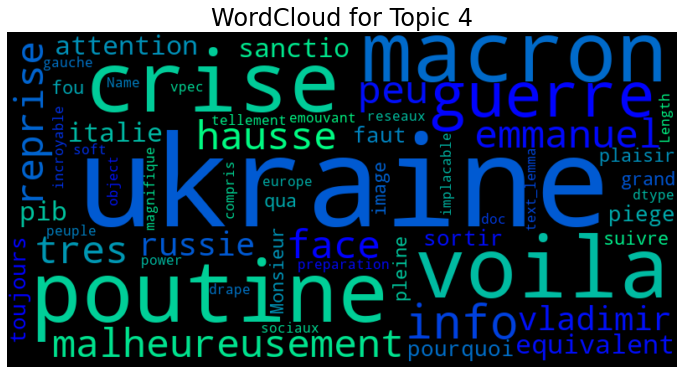

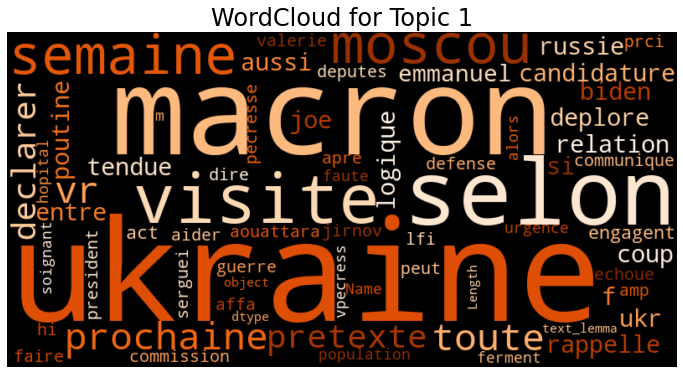

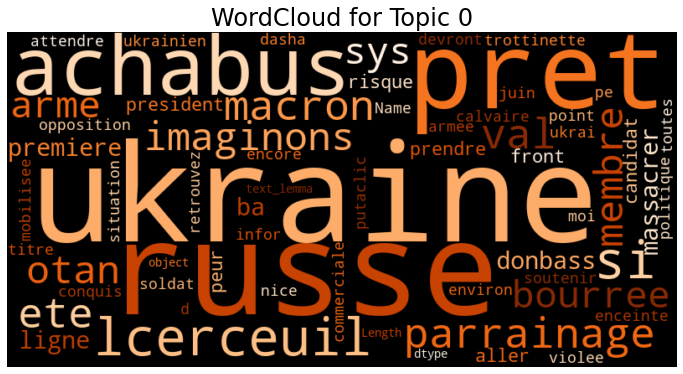

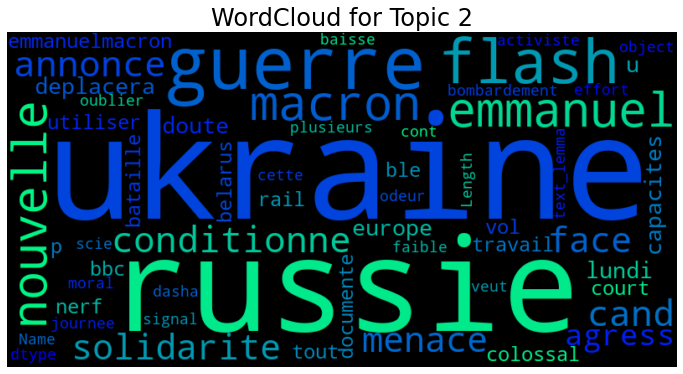

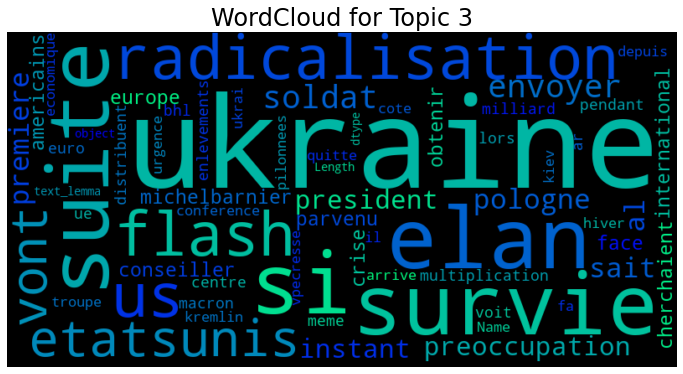

In [35]:
make_cloud(data, df_dominant_topics_lemma, "lemma")

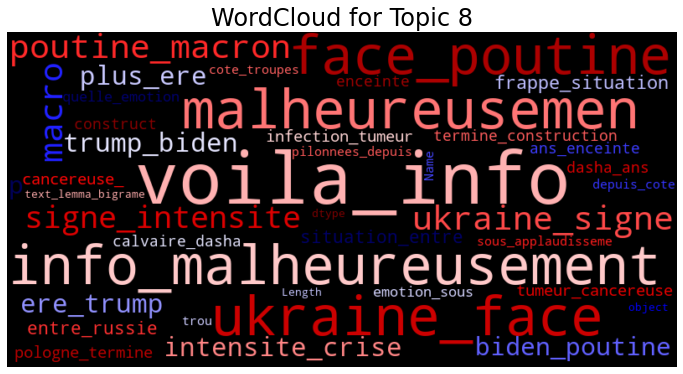

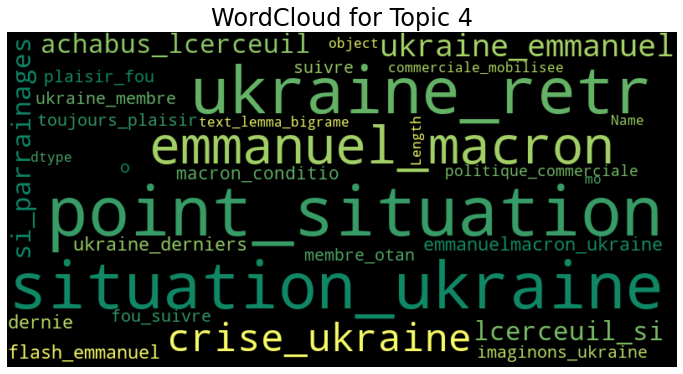

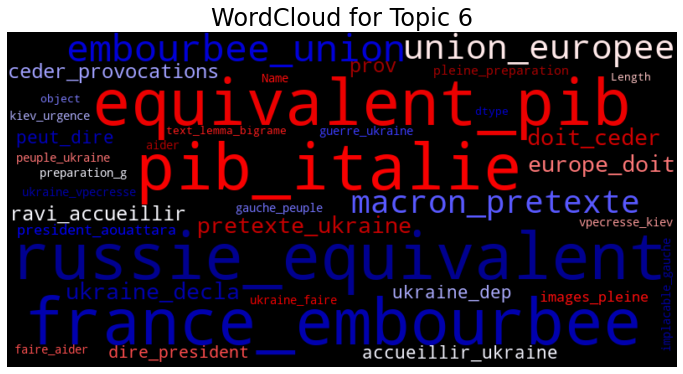

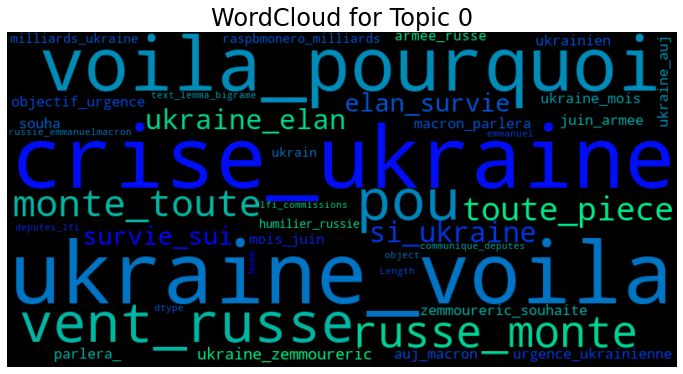

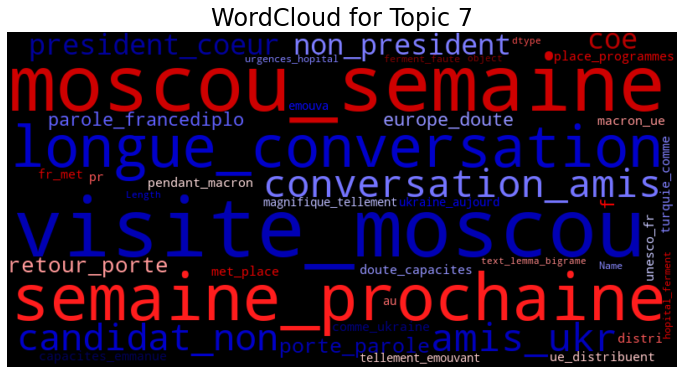

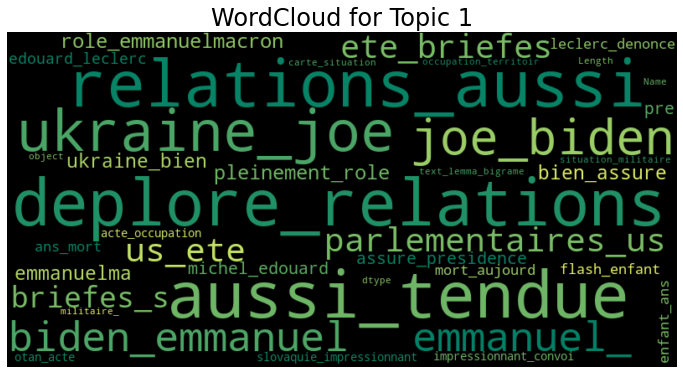

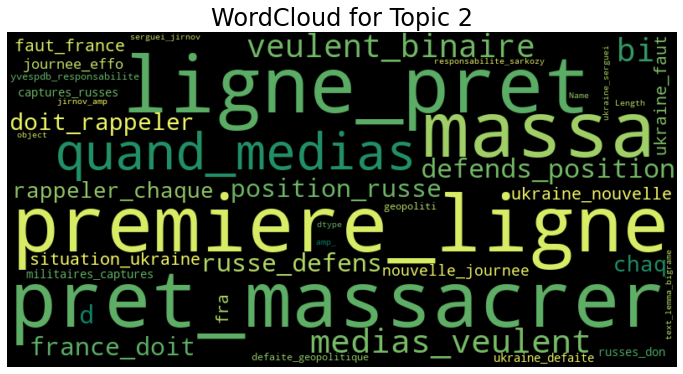

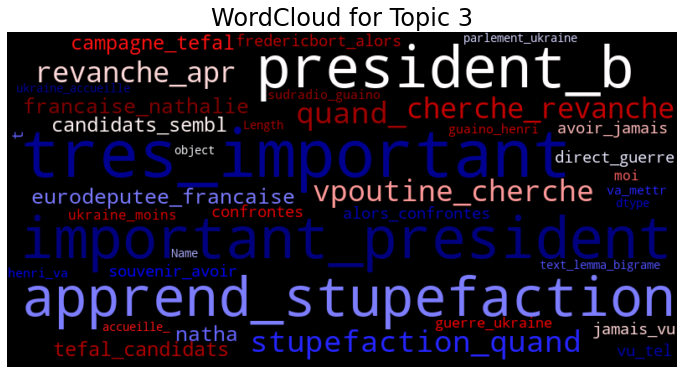

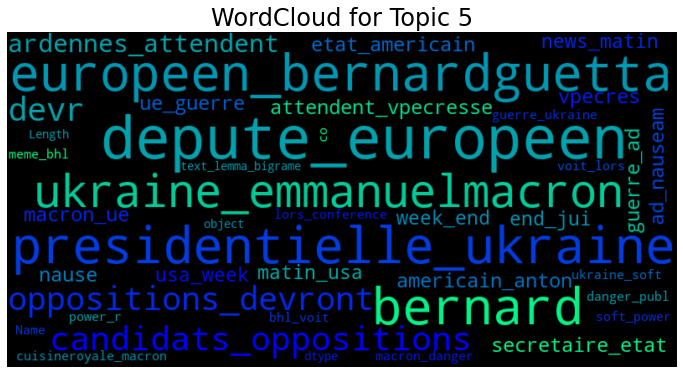

In [36]:
make_cloud(data, df_dominant_topics_bigrame, "lemma_bigrame")

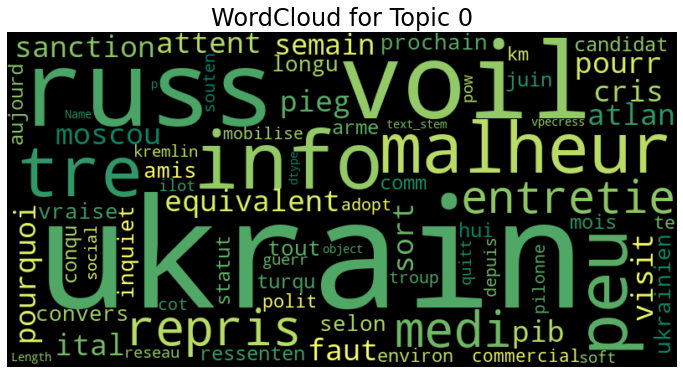

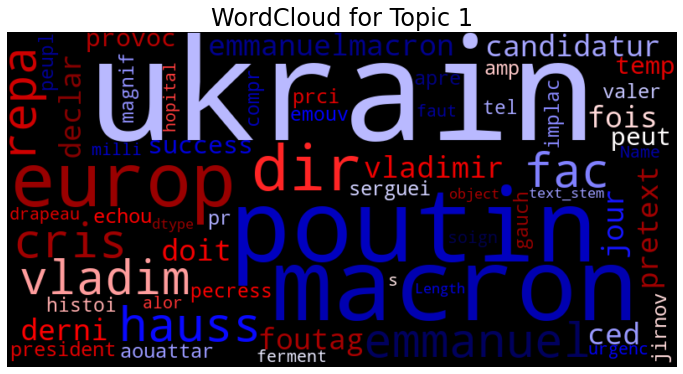

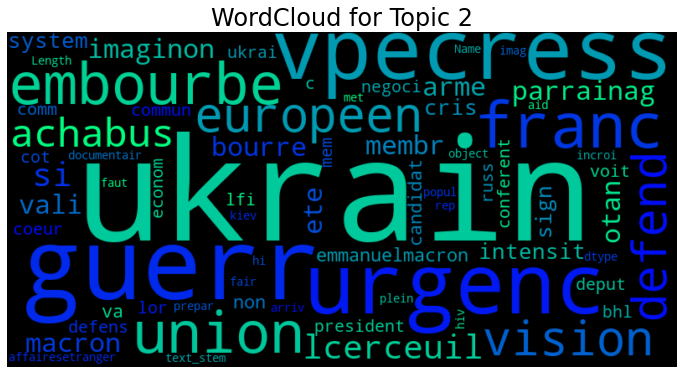

In [37]:
make_cloud(data, df_dominant_topics_stem, "stem")

In [52]:
### Word count and importance of key terms into the "optimal" topics

word  topic_id  importance  word_count
0     ete         0    0.024455        1220
1  depuis         0    0.020535        1030
2    kiev         0    0.019015        1197
3   cette         0    0.017311        1438
4   apres         0    0.016841         906

In [67]:
topics = lda_lemma.show_topics(formatted=False)
data_flat = [word for word_list in text_tokens_lemma for word in word_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
        
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count']) 

In [89]:
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd
from plotly.subplots import make_subplots

nb_topics = df["topic_id"].unique()
fig = make_subplots(rows=len(nb_topics), cols=1, start_cell="bottom-left",
                   subplot_titles= ("topic 1", "topic 2", "topic 3", "topic 4", "topic 5"))
for i in nb_topics:
    print(i)
    fig.add_trace(go.Bar(x=df[df['topic_id']==i]["word"], y=df[df['topic_id']==i]['word_count']),
                        row=i+1, col=1)
    fig.update_layout(barmode='stack',
                      xaxis={'categoryorder': 'total descending'})
fig.show()


fig = make_subplots(rows=len(nb_topics), cols=1, start_cell="bottom-left",
                   subplot_titles= ("topic 1", "topic 2", "topic 3", "topic 4", "topic 5"))
for i in nb_topics:
    print(i)
    sizeref = df[df['topic_id']==i]["importance"].max() / 100 ** 2

    fig.add_trace(go.Scatter(x=df[df['topic_id']==i]["importance"],
                             y=df[df['topic_id']==i]['word_count'],
                             text=df[df['topic_id']==i]["word"],
                             marker_size=df[df['topic_id']==i]["importance"]),
                        row=i+1, col=1)
    fig.update_traces(mode='markers', marker=dict(sizemode='area',
                                              line_width=2))
fig.show()

# fig = px.scatter(df[df['topic_id']==0], x="importance", y='word_count', color='word', size='importance' )
# fig.show()

0
1
2
3
4


C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



0
1
2
3
4


C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\vnarv\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



word  topic_id  importance  word_count
0            ete         0    0.024455        1220
1         depuis         0    0.020535        1030
2           kiev         0    0.019015        1197
3          cette         0    0.017311        1438
4          apres         0    0.016841         906
5           jour         0    0.015848         873
6       francais         0    0.015361         735
7          civil         0    0.015188         791
8      situation         0    0.013533         776
9        donbass         0    0.013210         461
10       poutine         1    0.035072        3342
11        macron         1    0.034137        1486
12      zelensky         1    0.020893         973
13          otan         1    0.017376        1062
14         comme         1    0.014290         979
15     president         1    0.013731        1236
16            va         1    0.013705         803
17         faire         1    0.013391         910
18            si         1    0.012841         822
19         crime         1    0.011850         443
20         russe         2    0.092025        4291
21         armee         2    0.021068         821
22        direct         2    0.019813         818
23          mort         2    0.019777         453
24      personne         2    0.011673         524
25       annonce         2    0.011652         516
26  bombardement         2    0.010456         412
27           sou         2    0.010317         498
28         grand         2    0.009255         636
29        combat         2    0.008980         367
30     ukrainien         3    0.047739        3239
31        russie         3    0.039517        4861
32            ue         3    0.023071         723
33          pays         3    0.020651        1325
34          arme         3    0.017990         912
35         monde         3    0.011274         686
36         force         3    0.010378         724
37          tout         3    0.010222         894
38    europeenne         3    0.010133         473
39        soldat         3    0.009498         450
40        guerre         4    0.075560        5385
41        france         4    0.029455        1923
42          plus         4    0.027448        1975
43        contre         4    0.020503        1486
44        europe         4    0.020150        1299
45        russie         4    0.018694        4861
46          fait         4    0.015929        1121
47       soutien         4    0.012949         789
48          etre         4    0.011653        1009
49     militaire         4    0.011096         861

[(0,
  [('ete', 0.024455307),
   ('depuis', 0.020534592),
   ('kiev', 0.01901542),
   ('cette', 0.017311368),
   ('apres', 0.016840754),
   ('jour', 0.015848191),
   ('francais', 0.015361413),
   ('civil', 0.015187695),
   ('situation', 0.013533255),
   ('donbass', 0.013210153)]),
 (1,
  [('poutine', 0.03507164),
   ('macron', 0.03413701),
   ('zelensky', 0.020893065),
   ('otan', 0.0173761),
   ('comme', 0.014290294),
   ('president', 0.013730585),
   ('va', 0.013704667),
   ('faire', 0.013390754),
   ('si', 0.012841345),
   ('crime', 0.011849922)]),
 (2,
  [('russe', 0.09202451),
   ('armee', 0.021068025),
   ('direct', 0.019812793),
   ('mort', 0.01977741),
   ('personne', 0.011672822),
   ('annonce', 0.011651594),
   ('bombardement', 0.010455515),
   ('sou', 0.010316845),
   ('grand', 0.009255304),
   ('combat', 0.008980071)]),
 (3,
  [('ukrainien', 0.04773903),
   ('russie', 0.03951739),
   ('ue', 0.0230706),
   ('pays', 0.02065145),
   ('arme', 0.01798969),
   ('monde', 0.0112744

In [33]:
df_dominant_topics.head()

Dominant_Topic  Perc_Contribution  \
0               4             0.4574   
1               1             0.2561   
2               4             0.3778   
3               4             0.3595   
4               4             0.3188   

                                      Topic_Keywords  \
0  guerre, france, plus, contre, europe, russie, ...   
1  poutine, macron, zelensky, otan, comme, presid...   
2  guerre, france, plus, contre, europe, russie, ...   
3  guerre, france, plus, contre, europe, russie, ...   
4  guerre, france, plus, contre, europe, russie, ...   

                                                   0  
0  [voila, info, malheureusement, tres, peu, repr...  
1           [ukraine, face, poutine, macron, hausse]  
2  [crise, ukraine, emmanuel, macron, vladimir, p...  
3  [russie, equivalent, pib, italie, attention, s...  
4  [crise, ukraine, voila, pourquoi, faut, sortir...

In [34]:
fig = px.bar(df_dominant_topics, x=' 	Dominant_Topic', y='pop')

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
19739        19739               4              0.3047   
19740        19740               0              0.2768   
19741        19741               3              0.2985   
19742        19742               1              0.3527   
19743        19743               1              0.2381   
19744        19744               4              0.3361   
19745        19745               1              0.3105   
19746        19746               4              0.2951   
19747        19747               4              0.3462   
19748        19748               1              0.3927   

                                                Keywords  \
19739  guerre, france, plus, contre, europe, russie, ...   
19740  ete, depuis, kiev, cette, apres, jour, francai...   
19741  ukrainien, russie, ue, pays, arme, monde, forc...   
19742  poutine, macron, zelensky, otan, comme, presid...   
19743  poutine, macron, zelensky, otan, comme, presid...   
19744  guerre, france, plus, contre, europe, russie, ...   
19745  poutine, macron, zelensky, otan, comme, presid...   
19746  guerre, france, plus, contre, europe, russie, ...   
19747  guerre, france, plus, contre, europe, russie, ...   
19748  poutine, macron, zelensky, otan, comme, presid...   

                                                    Text  
19739  [image, pleine, preparation, guerre, incroyabl...  
19740  [politique, commerciale, mobilisee, soutenir, ...  
19741  [pilonnees, depuis, cote, troupe, kremlin, qui...  
19742  [ukraine, serguei, jirnov, amp, valerie, pecre...  
19743  [ukraine, vpecresse, kiev, urgence, hiver, arr...  
19744  [magnifique, tellement, emouvant, ukraine, eur...  
19745  [guerre, ukraine, faire, aider, population, vp...  
19746  [guerre, ukraine, soft, power, reseaux, sociau...  
19747  [implacable, gauche, peuple, ukraine, compris,...  
19748  [urgence, hopital, ferment, faute, soignant, a...

### La sentence la plus représentative de chaque topic

In [41]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_dominant_topics.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative_Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0          0              0.4672   
1          1              0.5489   
2          2              0.4381   
3          3              0.5398   
4          4              0.5431   

                                            Keywords  \
0  ete, depuis, kiev, cette, apres, jour, francai...   
1  poutine, macron, zelensky, otan, comme, presid...   
2  russe, armee, direct, mort, personne, annonce,...   
3  ukrainien, russie, ue, pays, arme, monde, forc...   
4  guerre, france, plus, contre, europe, russie, ...   

                                 Representative_Text  
0  [guerre, ukraine, corps, retrouves, main, liee...  
1  [jamais, si, bien, servi, soi, meme, france, m...  
2  [flash, ukraine, troupe, russe, approche, kher...  
3  [pologne, slovaquie, roumanie, hongrie, pays, ...  
4  [air, presidentielle, soir, france, tv, caroli...

In [40]:
sent_topics_sorteddf_mallet.shape

(5, 4)